### Basic Imports and Helper Functions

In [1]:
# Imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
def load_data_DB1(subject,exercise):
    data = loadmat(f'../Dataset/DB1/s{subject}/S{subject}_A1_E{exercise}.mat')
    return data

In [3]:
def get_start_indexes(data,movement,target):
    start_indexes=[]
    for idx,move in enumerate(data[target]):
        if move[0] == movement and data[target][idx-1][0] == 0:
            start_indexes.append(idx)
        if len(start_indexes) == 10:
            break
    return start_indexes

In [4]:
def get_movement_df(data,movement,target):
    '''
    Returns the repetitions of a movement based on fixed length of repetition.
    if target is stimulus then each rep takes 5 seconds but if target is restimulus then each rep takes 2 seconds
    '''
    start_indexes = get_start_indexes(data,movement,target)
    df= pd.DataFrame()
    step = 500 if target == 'stimulus' else 200
    for i in start_indexes:
        new_row = data['emg'][i:i+step].flatten()
        df = df.append(pd.Series(new_row),ignore_index=True)
    target_movement = np.full((10,1),movement,dtype=int)
    df['target_movement'] = target_movement
    return df

In [5]:
def get_full_repetitions(data, movement):
    '''
    Returns a dataframe with the 10 repetitions of a movement  based on restimulus.
    The returned dataframe considers the varying length of each repetition.
    '''
    df = pd.DataFrame()
    restimulus_indices = get_start_indexes(data=data, movement=movement, target="restimulus")
    for i in restimulus_indices:
        j = i
        while data["restimulus"][j] == movement:
            j+=1
        repetition_df = pd.DataFrame(data["emg"][i:j].flatten().reshape(1,len(data["emg"][i:j].flatten())))
        repetition_df["target"] = movement
        df = df.append(repetition_df, ignore_index=True)

    col_names = list(range(0,df.shape[1] - 1))
    col_names.append("target")
    df = df.reindex(columns=col_names)
    return df

In [6]:
from scipy import interpolate
import math

def interpolate_dataframe(df):
    '''
    Takes a dataframe with NaN and returns an interpolated version of the dataframe with no NaNs.
    '''
    data = df.drop("target", axis=1)
    target_col = df["target"]
    
    max_row_length = data.shape[1]
    max_range = list(range(0, max_row_length))
    for idx,row in data.iterrows():
        current_row_length = len(row.dropna())
        current_range = list(range(0, current_row_length))
        new_row = pd.Series(index=max_range, dtype='float64')
        for i in current_range:
            j = math.ceil(i * max_row_length / current_row_length)
            new_row.iloc[j] = row.iloc[i]
        
        new_row.interpolate(method="linear",inplace=True)
        data.iloc[idx] = new_row
    data["target"] = target_col
    return data

In [7]:
from scipy import interpolate
import math

def interpolate_dataframe_with_length(df, max_length):
    '''
    Takes a dataframe and a desired length for data (ignoring target column) with NaN and returns an interpolated version of the dataframe with no NaNs.
    '''
    data = df.drop("target", axis=1)
    target_col = df["target"]
    
    max_row_length = max_length
    max_range = list(range(0, max_row_length))
    
    # Creating datafram to hold new data with new length
    new_data = pd.DataFrame(columns=max_range)

        
    for idx,row in data.iterrows():
        current_row_length = len(row.dropna())
        current_range = list(range(0, current_row_length))
        new_row = pd.Series(index=max_range, dtype='float64')
        for i in current_range:
            j = math.ceil(i * max_row_length / current_row_length)
            new_row.iloc[j] = row.iloc[i]
        
        new_row.interpolate(method="linear",inplace=True)
        new_data = new_data.append(new_row, ignore_index=True)
    new_data["target"] = target_col
    return new_data

# Visualizing signals before and after interpolation

In [205]:
# Loading data of exercise 1 for subject 1
sub1_ex1 = load_data_DB1(subject=1, exercise=1)

# Get resimulus indexes for movement 1
restimulus_idxs_move1 = get_start_indexes(data=sub1_ex1, movement=1, target="restimulus")

# Concatenating every repetition of movement 1 in exercise 1 based on how long it takes and not fixed size
move1_df = pd.DataFrame()
for i in restimulus_idxs_move1:
    j = i
    while sub1_ex1["restimulus"][j] == 1:
        j+=1
    rep_df = pd.DataFrame(sub1_ex1["emg"][i:j].flatten().reshape(1,len(sub1_ex1["emg"][i:j].flatten())))
    rep_df["target"] = 1
    move1_df = move1_df.append(rep_df, ignore_index=True)

col_names = list(range(0,move1_df.shape[1]-1))
col_names.append("target")
move1_df = move1_df.reindex(columns=col_names)
len(move1_df.iloc[4])

4381

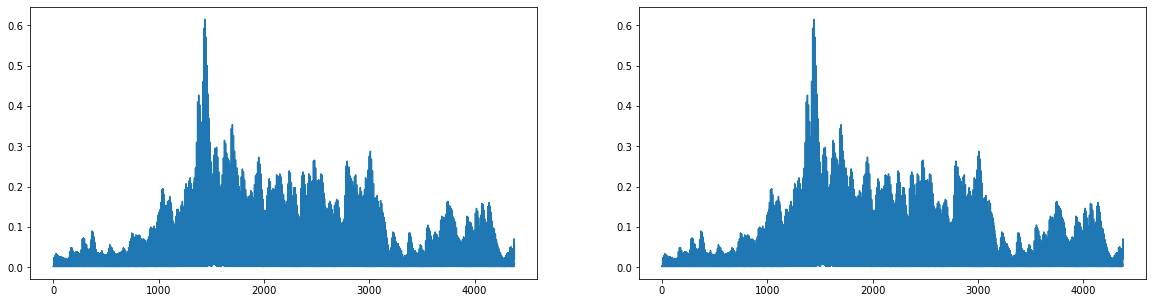

In [206]:
import math

X = move1_df.drop("target", axis=1)
y = move1_df["target"]

max_size = move1_df.shape[1] - 1 
x_vals = list(range(0, len(X.loc[4].dropna(axis=0))))
y_vals = X.loc[4].dropna()

f = interpolate.interp1d(x_vals, y_vals)

x_new = list(range(0,max_size))
y_new = pd.Series(index=x_new, dtype='float64')


for i in x_vals:
    j = math.ceil(i * max_size / len(x_vals))
    y_new.iloc[j] = y_vals.iloc[i]


y_new.interpolate(inplace=True)

fig , (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

ax1.plot(x_vals, y_vals)
ax2.plot(x_new, y_new);

In [9]:
sub1_ex1 = load_data_DB1(subject=1, exercise=1)

# Trying to classify 5 movements from exercise 1 in subject 1
x = pd.DataFrame()
m1 = get_full_repetitions(data=sub1_ex1,movement=1)
m2 = get_full_repetitions(data=sub1_ex1,movement=2)
m3 = get_full_repetitions(data=sub1_ex1,movement=3)
m4 = get_full_repetitions(data=sub1_ex1,movement=4)
m5 = get_full_repetitions(data=sub1_ex1,movement=5)
x = x.append(m1,ignore_index=True)
x = x.append(m2, ignore_index=True)
x = x.append(m3, ignore_index=True)
x = x.append(m4, ignore_index=True)
x = x.append(m5, ignore_index=True)

x.head()

,0,1,2,3,4,5,6,7,8,9,...,5230,5231,5232,5233,5234,5235,5236,5237,5238,5239
0,0.0171,0.0073,0.0024,0.0024,0.0024,0.0024,0.0757,0.0317,0.0024,0.0146,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0488,0.0073,0.0024,0.0024,0.0024,0.0024,0.0171,0.0488,0.0024,0.0049,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0073,0.0073,0.0024,0.0024,0.0024,0.0024,0.0269,0.0391,0.0024,0.0049,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0049,0.0024,0.0024,0.0024,0.0024,0.0024,0.0659,0.0342,0.0024,0.0098,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0024,0.0024,0.0024,0.0049,0.0024,0.0024,0.0098,0.0244,0.0049,0.0024,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Dropping columns with Nan values 
df_no_interolation = x.dropna(axis=1)

X = df_no_interolation.drop("target", axis=1)
y = df_no_interolation["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2)

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

np.array(y_test) , rfc.predict(X_test)

(array([5, 1, 5, 2, 4, 4, 3, 2, 1, 3], dtype=int64),
 array([5, 1, 5, 2, 5, 4, 3, 2, 1, 3], dtype=int64))

In [23]:
rfc.score(X_test, y_test)

0.9

In [118]:
rfc.predict_proba(X_test)

array([[0.13, 0.44, 0.43, 0.  , 0.  ],
       [0.89, 0.06, 0.03, 0.01, 0.01],
       [0.08, 0.  , 0.08, 0.04, 0.8 ],
       [0.09, 0.07, 0.81, 0.  , 0.03],
       [0.8 , 0.08, 0.05, 0.05, 0.02],
       [0.08, 0.  , 0.03, 0.12, 0.77],
       [0.  , 0.  , 0.  , 0.88, 0.12],
       [0.06, 0.01, 0.01, 0.85, 0.07],
       [0.07, 0.83, 0.06, 0.04, 0.  ],
       [0.02, 0.92, 0.05, 0.01, 0.  ]])

**Trying Logistic regression for classifying first 5 movements of one exercise of one subject**

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

df_interpolated = interpolate_dataframe(x)

np.random.seed(0)

# Creating a model to classify 2 movements after interpolation
X = df_interpolated.drop("target", axis=1)
y = df_interpolated["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2)


log = LogisticRegression(max_iter=10000).fit(X_train, y_train)

log.score(X_test, y_test)

0.5

**Trying Random Forest Classifier for classifying first 5 movements of one exercise of one subject**

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

df_interpolated = interpolate_dataframe(x)

np.random.seed(0)

# Creating a model to classify 2 movements after interpolation
X = df_interpolated.drop("target", axis=1)
y = df_interpolated["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2)

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

rfc.score(X_test, y_test)

0.5

**Trying AdaBoost Classifier for classifying first 5 movements of one exercise of one subject**

In [13]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

df_interpolated = interpolate_dataframe(x)

np.random.seed(0)

# Creating a model to classify 2 movements after interpolation
X = df_interpolated.drop("target", axis=1)
y = df_interpolated["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2)

abc = AdaBoostClassifier()
abc.fit(X_train, y_train)

abc.score(X_test, y_test)

0.4

**Trying GradientBoosting Classifier for classifying first 5 movements of one exercise of one subject**

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

df_interpolated = interpolate_dataframe(x)

np.random.seed(0)

# Creating a model to classify 2 movements after interpolation
X = df_interpolated.drop("target", axis=1)
y = df_interpolated["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2)

gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

gbc.score(X_test, y_test)

0.2

**Trying PCA components with Random Forest Classifier for the first 5 movements of exercise 1 for subject 1**

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

df_interpolated = interpolate_dataframe(x)

np.random.seed(0)

# Creating a model to classify 2 movements after interpolation
X = df_interpolated.drop("target", axis=1)
y = df_interpolated["target"]

pca = PCA(n_components=0.9)
X_PCA = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_PCA, y,stratify=y, test_size=0.2)

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

rfc.score(X_test, y_test)

0.7

# Fitting a model to classify all movements in exercise 1 for subject 1

In [7]:
sub1_ex1 = load_data_DB1(subject=11, exercise=2)

# Creating a list from range 1 to 12 because exercise 1 has 12 movements
movements = list(range(1,18))

# Add all repetitions of all movements to one dataframe
sub1_ex1_df = pd.DataFrame()
for m in movements:
    sub1_ex1_df = sub1_ex1_df.append(get_full_repetitions(data=sub1_ex1,movement=m),ignore_index=True)

sub1_ex1_df

,0,1,2,3,4,5,6,7,8,9,...,5520,5521,5522,5523,5524,5525,5526,5527,5528,5529
0,0.0024,0.0098,0.3955,0.2783,0.0049,0.0366,0.5981,0.2075,0.4565,0.3906,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0098,0.0342,0.4639,0.3052,0.0024,0.0439,0.7568,0.1782,0.6079,0.5420,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0024,0.0073,1.1108,0.7227,0.0195,0.1025,1.5991,0.3369,0.9009,1.3745,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0024,0.0708,0.4639,0.2759,0.0098,0.0391,0.6567,0.2710,0.5713,0.7227,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0073,0.0024,0.3711,0.3979,0.0024,0.0122,0.4883,0.1489,0.4663,0.4810,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,0.0659,0.0049,0.0122,0.1172,0.0049,0.0391,0.5713,0.5273,0.0122,0.4712,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166,0.0562,0.0024,0.0024,0.0024,0.0024,0.0122,0.1636,0.1147,0.0024,0.0269,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167,0.0391,0.0024,0.0049,0.0024,0.0024,0.0269,0.1245,0.2148,0.0024,0.1147,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,0.0635,0.0024,0.0024,0.0024,0.0024,0.0024,0.1465,0.1025,0.0024,0.0952,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Interpolating the dataframe so that there are no NaNs
sub1_ex1_df_interpolated = interpolate_dataframe(sub1_ex1_df)
sub1_ex1_df_interpolated

,0,1,2,3,4,5,6,7,8,9,...,5521,5522,5523,5524,5525,5526,5527,5528,5529,target
0,0.0024,0.006100,0.009800,0.20265,0.39550,0.3369,0.27830,0.14160,0.0049,0.02075,...,0.00240,0.02195,0.04150,0.17210,0.30270,0.30515,0.30760,0.1611,0.0146,1
1,0.0098,0.017933,0.026067,0.03420,0.24905,0.4639,0.38455,0.30520,0.1538,0.00240,...,0.13305,0.21970,0.16845,0.11720,0.30030,0.48340,0.29665,0.1099,0.1099,1
2,0.0024,0.004850,0.007300,1.11080,0.72270,0.0195,0.06100,0.10250,1.5991,0.33690,...,0.63230,0.42480,0.00240,0.07080,0.20265,0.33450,0.16110,0.5273,0.1147,1
3,0.0024,0.036600,0.070800,0.46390,0.27590,0.0098,0.03910,0.65670,0.2710,0.57130,...,0.17330,1.08400,0.89840,0.03660,0.13430,2.23880,0.42970,0.7935,1.5063,1
4,0.0073,0.004850,0.002400,0.37110,0.39790,0.0024,0.00730,0.01220,0.4883,0.14890,...,0.14400,0.22460,0.00240,0.00240,0.13550,0.26860,0.46390,0.2417,0.2344,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,0.0659,0.035400,0.004900,0.00855,0.01220,0.1172,0.06105,0.00490,0.0220,0.03910,...,0.00240,0.00730,0.20505,0.40280,0.31615,0.22950,0.15140,0.1416,0.1318,17
166,0.0562,0.029300,0.002400,0.00240,0.00240,0.0024,0.01220,0.08790,0.1636,0.11470,...,0.00490,0.00240,0.00730,0.04025,0.07320,0.41990,0.29300,0.0220,0.1440,17
167,0.0391,0.020750,0.002400,0.00490,0.00240,0.0024,0.00240,0.02690,0.1245,0.16965,...,0.00240,0.00240,0.00240,0.03660,0.35890,0.25635,0.15380,0.0024,0.1294,17
168,0.0635,0.032950,0.002400,0.00240,0.00240,0.0024,0.00240,0.07445,0.1465,0.10250,...,0.08540,0.00240,0.00240,0.02075,0.03910,0.27590,0.26120,0.0439,0.0073,17


In [14]:
sub1_ex1_df_no_missing = sub1_ex1_df.fillna(0)
sub1_ex1_df_no_missing

,0,1,2,3,4,5,6,7,8,9,...,4950,4951,4952,4953,4954,4955,4956,4957,4958,4959
0,0.0366,0.0024,0.0024,0.0024,0.0049,0.0537,0.1318,0.0562,0.0293,0.0146,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0342,0.0024,0.0024,0.0024,0.0024,0.0146,0.2173,0.0415,0.0439,0.0220,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0513,0.0073,0.0024,0.0024,0.0024,0.0220,0.1318,0.0415,0.0513,0.0342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0732,0.0073,0.0024,0.0024,0.0024,0.0024,0.2002,0.0757,0.0244,0.0684,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0293,0.0049,0.0024,0.0024,0.0024,0.0342,0.0586,0.0293,0.0269,0.0171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,0.0220,0.0024,0.0024,0.0122,0.0024,0.0854,0.4639,0.0757,0.0146,0.3027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
166,0.0366,0.0024,0.0024,0.0122,0.0073,0.0830,0.4053,0.0854,0.0073,0.2295,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
167,0.0293,0.0024,0.0024,0.0024,0.0024,0.0806,0.3540,0.0732,0.0024,0.2148,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168,0.0342,0.0024,0.0098,0.0098,0.0024,0.0781,0.2759,0.1099,0.0098,0.0977,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

np.random.seed(42)

X = sub1_ex1_df_no_missing.drop("target", axis=1)
y = sub1_ex1_df_no_missing["target"]

# Splitting the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

clf = RandomForestClassifier(n_estimators=100)
cross_val_score(clf, X, y, cv=4)

array([0.8372093 , 0.97674419, 0.95238095, 0.95238095])

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

np.random.seed(42)

X = sub1_ex1_df_interpolated.drop("target", axis=1)
y = sub1_ex1_df_interpolated["target"]

clf = RandomForestClassifier(n_estimators=200)

print(f"5 folds Cross Validation mean accuracy {np.mean(cross_val_score(clf,X, y, cv=5))}")

# Splitting the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

clf = RandomForestClassifier(n_estimators=200).fit(X_train, y_train)

print(f"Accuracy of training data {clf.score(X_train, y_train)*100 :.2f} %")
print(f"Accuracy of test data {clf.score(X_test, y_test)*100 :.2f} %")

5 folds Cross Validation mean accuracy 0.5294117647058824
Accuracy of training data 100.00 %
Accuracy of test data 58.82 %


**Trying KFold for random forest classifier**

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

np.random.seed(42)

X = sub1_ex1_df_interpolated.drop("target", axis=1)
y = sub1_ex1_df_interpolated["target"]

kf = KFold(shuffle=True,n_splits=5)
clf = RandomForestClassifier(n_estimators=200)

print(f"5 folds Cross Validation mean accuracy {np.mean(cross_val_score(clf,X, y, cv=kf))}")

# Splitting the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

clf = RandomForestClassifier(n_estimators=200).fit(X_train, y_train)

print(f"Accuracy of training data {clf.score(X_train, y_train)*100 :.2f} %")
print(f"Accuracy of test data {clf.score(X_test, y_test)*100 :.2f} %")

5 folds Cross Validation mean accuracy 0.2882352941176471
Accuracy of training data 100.00 %
Accuracy of test data 44.12 %


###### Fitting Linear SVC model

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, KFold

np.random.seed(200)

X = sub1_ex1_df_interpolated.drop("target", axis=1)
y = sub1_ex1_df_interpolated["target"]

kf = KFold(n_splits=5, shuffle=True)
linear_svc = LinearSVC()

print(f"5 folds Cross Validation mean accuracy {np.mean(cross_val_score(linear_svc,X, y, cv=kf))}")

# Splitting the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

linear_svc = LinearSVC().fit(X_train, y_train)

print(f"Accuracy of training data {linear_svc.score(X_train, y_train)*100 :.2f} %")
print(f"Accuracy of test data {linear_svc.score(X_test, y_test)*100 :.2f} %")


5 folds Cross Validation mean accuracy 0.15882352941176472
Accuracy of training data 100.00 %
Accuracy of test data 17.65 %


###### Fitting KNN classifier

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

np.random.seed(42)

X = sub1_ex1_df_interpolated.drop("target", axis=1)
y = sub1_ex1_df_interpolated["target"]

knn = KNeighborsClassifier(n_neighbors=5)

print(f"5 folds Cross Validation mean accuracy {np.mean(cross_val_score(knn,X, y, cv=4))}")

# Splitting the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

knn = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

print(f"Accuracy of training data {knn.score(X_train, y_train)*100 :.2f} %")
print(f"Accuracy of test data {knn.score(X_test, y_test)*100 :.2f} %")


5 folds Cross Validation mean accuracy 0.17594130675526026
Accuracy of training data 19.69 %
Accuracy of test data 18.60 %


###### Fitting Logistic Regression Model

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

np.random.seed(42)

X = sub1_ex1_df_interpolated.drop("target", axis=1)
y = sub1_ex1_df_interpolated["target"]

log = LogisticRegression(max_iter=10000,penalty='l1',solver='liblinear')

print(f"5 folds Cross Validation mean accuracy {np.mean(cross_val_score(log,X, y, cv=4))}")

# Splitting the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

log = LogisticRegression(max_iter=10000,penalty='l1',solver='liblinear').fit(X_train, y_train)

print(f"Accuracy of training data {log.score(X_train, y_train)*100 :.2f} %")
print(f"Accuracy of test data {log.score(X_test, y_test)*100 :.2f} %")


5 folds Cross Validation mean accuracy 0.19975083056478404
Accuracy of training data 100.00 %
Accuracy of test data 20.93 %


**Plotting to visualize effect before and after interpolation**

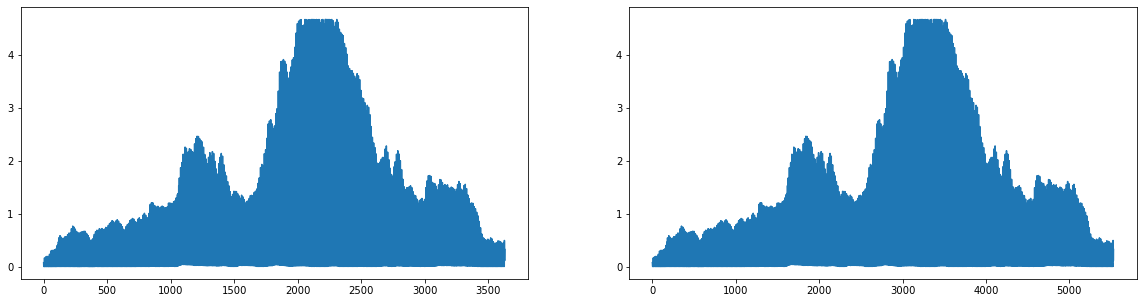

In [18]:
# Plotting to visualize effect of interpolation

idx = 169
sig = sub1_ex1_df.iloc[idx].drop("target").dropna()
r1 = list(range(0, len(sig)))

sig_interpolated = sub1_ex1_df_interpolated.iloc[idx].drop("target")
r2 = list(range(0, len(sig_interpolated)))

# Plotting 
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

ax1.plot(r1,sig)
ax2.plot(r2,sig_interpolated);

## Trying Random Forest Classifier for each subject on exercise 1 using linear interpolation and calculate the avg

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

training_acc_subjects = []
test_acc_subjects = []

random_states = [0,1,10,42,66,73,99,100,101,200]
ex1_movements = list(range(1,13))

# Iterate over 27 subjects of Database 1 and trying to classify exercise 1 
for sub in list(range(1,28)):
    
    # Load the data 
    data = load_data_DB1(subject=sub, exercise=1)
    
    # Iterate over all movements and add them into a df
    df = pd.DataFrame()
    for m in ex1_movements:
        df = df.append(get_full_repetitions(data=data, movement=m),ignore_index=True)
    
    # Interpolate the dataframe to fill NaN values using linear interpolation
    df_interpolated = interpolate_dataframe(df)
    
    # Getting X & y
    X = df_interpolated.drop("target", axis=1)
    y = df_interpolated["target"]

    # Getting imp features using PCA
    pca = PCA(n_components=0.95)
    X_transformed = pca.fit_transform(X)
    
    training_acc_states = []
    test_acc_states = []
    # Iterate over the 10 different random states to fit the model 
    for r in random_states:
        
        # Splitting the data
        X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, stratify=y, test_size=0.2, random_state=r)
        clf = RandomForestClassifier(n_estimators=200)
        
        #Fitting the model
        clf.fit(X_train, y_train)
        training_acc_states.append(clf.score(X_train, y_train))
        test_acc_states.append(clf.score(X_test, y_test))
    
    training_mean_states = np.mean(training_acc_states)
    test_mean_states = np.mean(test_acc_states)
    
    print(f"Average Training Accuracy for subject {sub} for 10 random states is {training_mean_states}")
    print(f"Average Test Accuracy for subject {sub} for 10 random states is {test_mean_states}")
    training_acc_subjects.append(training_mean_states)
    test_acc_subjects.append(test_mean_states)


print(f"Average Training Accuracy for all subjects {np.mean(training_acc_subjects)}")
print(f"Average Test Accuracy for all subjects {np.mean(test_acc_subjects)}")



Average Training Accuracy for subject 1 for 10 random states is 1.0
Average Test Accuracy for subject 1 for 10 random states is 0.31250000000000006
Average Training Accuracy for subject 2 for 10 random states is 1.0
Average Test Accuracy for subject 2 for 10 random states is 0.30416666666666664
Average Training Accuracy for subject 3 for 10 random states is 1.0
Average Test Accuracy for subject 3 for 10 random states is 0.3541666666666667
Average Training Accuracy for subject 4 for 10 random states is 1.0
Average Test Accuracy for subject 4 for 10 random states is 0.3458333333333333
Average Training Accuracy for subject 5 for 10 random states is 1.0
Average Test Accuracy for subject 5 for 10 random states is 0.4333333333333333
Average Training Accuracy for subject 6 for 10 random states is 1.0
Average Test Accuracy for subject 6 for 10 random states is 0.525
Average Training Accuracy for subject 7 for 10 random states is 1.0
Average Test Accuracy for subject 7 for 10 random states is 0

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

training_acc_subjects = []
test_acc_subjects = []

random_states = [0,1,10,42,66,73,99,100,101,200]
ex1_movements = list(range(1,13))

# Iterate over 27 subjects of Database 1 and trying to classify exercise 1 
for sub in list(range(1,28)):
    
    df = pd.DataFrame()
    # Load the data for all subjects except 1 to do leave-one out classification
    for s in list(range(1,28)):
        if s != sub:
            data = load_data_DB1(subject=s, exercise=1)
            # Iterate over all movements and add them into a df
            for m in ex1_movements:
                df = df.append(get_full_repetitions(data=data, movement=m),ignore_index=True)
    print(df)
    break
    
    
 
#     # Interpolate the dataframe to fill NaN values using linear interpolation
#     df_interpolated = interpolate_dataframe(df)
    
#     # Getting X & y
#     X = df_interpolated.drop("target", axis=1)
#     y = df_interpolated["target"]

#     # Getting imp features using PCA
#     pca = PCA(n_components=0.95)
#     X_transformed = pca.fit_transform(X)
    
#     training_acc_states = []
#     test_acc_states = []
#     # Iterate over the 10 different random states to fit the model 
#     for r in random_states:
        
#         # Splitting the data
#         X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, stratify=y, test_size=0.2, random_state=r)
#         clf = RandomForestClassifier(n_estimators=200)
        
#         #Fitting the model
#         clf.fit(X_train, y_train)
#         training_acc_states.append(clf.score(X_train, y_train))
#         test_acc_states.append(clf.score(X_test, y_test))
    
#     training_mean_states = np.mean(training_acc_states)
#     test_mean_states = np.mean(test_acc_states)
    
#     print(f"Average Training Accuracy for subject {sub} for 10 random states is {training_mean_states}")
#     print(f"Average Test Accuracy for subject {sub} for 10 random states is {test_mean_states}")
#     training_acc_subjects.append(training_mean_states)
#     test_acc_subjects.append(test_mean_states)


# print(f"Average Training Accuracy for all subjects {np.mean(training_acc_subjects)}")
# print(f"Average Test Accuracy for all subjects {np.mean(test_acc_subjects)}")



        0       1       2       3       4       5       6       7       8     \
0     0.2759  0.2148  0.0317  0.0684  0.0049  0.0024  0.0024  0.1050  0.0928   
1     0.2344  0.2026  0.1636  0.0610  0.0024  0.0024  0.0049  0.0391  0.5737   
2     0.2197  0.1489  0.3638  0.1099  0.0024  0.0024  0.0024  0.0415  0.4688   
3     0.2393  0.4688  0.3394  0.0464  0.0024  0.0024  0.0024  0.0928  0.4419   
4     0.0171  0.0928  0.2124  0.0659  0.0024  0.0049  0.0024  0.0024  0.5444   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
3115  0.2075  0.0513  0.0049  0.0024  0.0049  0.0024  0.0049  0.2368  0.0024   
3116  0.0537  0.0024  0.0049  0.0024  0.0049  0.0049  0.0049  0.1953  0.0049   
3117  0.0391  0.0146  0.0073  0.0024  0.0024  0.0024  0.0049  0.1514  0.0049   
3118  0.2246  0.0024  0.0049  0.0049  0.0049  0.0024  0.0049  0.3418  0.0024   
3119  0.2271  0.0195  0.0317  0.0098  0.0049  0.0024  0.0049  0.2466  0.0122   

        9     ...  5990  5991  5992  59

In [9]:
df_interpolated = interpolate_dataframe(df)

In [11]:
df_interpolated["target"].value_counts()

2     260
4     260
6     260
8     260
10    260
12    260
1     260
3     260
5     260
7     260
9     260
11    260
Name: target, dtype: int64

In [12]:
# Get X_test and y_test from subject 1
sub1 = load_data_DB1(subject=1, exercise=1)

sub1_df = pd.DataFrame()
for m in ex1_movements:
                sub1_df = sub1_df.append(get_full_repetitions(data=sub1, movement=m),ignore_index=True)

sub1_df

,0,1,2,3,4,5,6,7,8,9,...,5250,5251,5252,5253,5254,5255,5256,5257,5258,5259
0,0.0171,0.0073,0.0024,0.0024,0.0024,0.0024,0.0757,0.0317,0.0024,0.0146,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0488,0.0073,0.0024,0.0024,0.0024,0.0024,0.0171,0.0488,0.0024,0.0049,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0073,0.0073,0.0024,0.0024,0.0024,0.0024,0.0269,0.0391,0.0024,0.0049,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0049,0.0024,0.0024,0.0024,0.0024,0.0024,0.0659,0.0342,0.0024,0.0098,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0024,0.0024,0.0024,0.0049,0.0024,0.0024,0.0098,0.0244,0.0049,0.0024,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.0073,0.0024,0.0024,0.0024,0.0024,0.0024,0.0977,0.0903,0.0024,0.0366,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,0.0073,0.0024,0.0024,0.0024,0.0024,0.0049,0.0342,0.0757,0.0024,0.0098,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117,0.0049,0.0024,0.0024,0.0024,0.0024,0.0024,0.0024,0.0439,0.0024,0.0122,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118,0.0024,0.0024,0.0024,0.0024,0.0024,0.0024,0.0024,0.0586,0.0098,0.0269,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
X = df_interpolated.drop("target", axis=1)
y = df_interpolated["target"]

pca = PCA(n_components=0.95)
X_transformed = pca.fit_transform(X)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X, y)

RandomForestClassifier()

In [30]:
sub1_df_interpolated = interpolate_dataframe_with_length(sub1_df, X.shape[1])
sub1_df_interpolated

,0,1,2,3,4,5,6,7,8,9,...,5991,5992,5993,5994,5995,5996,5997,5998,5999,target
0,0.0171,0.012200,0.007300,0.004850,0.00240,0.0024,0.0024,0.0024,0.00240,0.0024,...,0.00240,0.064700,0.127000,0.090350,0.053700,0.028050,0.00240,0.01465,0.0269,1
1,0.0488,0.028050,0.007300,0.004850,0.00240,0.0024,0.0024,0.0024,0.00240,0.0024,...,0.00240,0.002400,0.052450,0.102500,0.051300,0.026850,0.00240,0.01340,0.0244,1
2,0.0073,0.007300,0.007300,0.004850,0.00240,0.0024,0.0024,0.0024,0.00240,0.0024,...,0.00240,0.002400,0.006100,0.009800,0.019500,0.010950,0.00240,0.01705,0.0317,1
3,0.0049,0.003650,0.002400,0.002400,0.00240,0.0024,0.0024,0.0024,0.00240,0.0024,...,0.00240,0.002400,0.039050,0.075700,0.054950,0.034200,0.01710,0.01100,0.0049,1
4,0.0024,0.002400,0.002400,0.002400,0.00365,0.0049,0.0024,0.0024,0.00610,0.0098,...,0.00240,0.002400,0.002400,0.002400,0.070800,0.039100,0.04885,0.05860,0.0220,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.0073,0.005667,0.004033,0.002400,0.00240,0.0024,0.0024,0.0024,0.00240,0.0024,...,0.04390,0.050433,0.056967,0.063500,0.032950,0.002400,0.00975,0.01710,0.0171,12
116,0.0073,0.006075,0.004850,0.003625,0.00240,0.0024,0.0024,0.0024,0.00240,0.0024,...,0.09280,0.062667,0.032533,0.002400,0.010567,0.018733,0.02690,0.02690,0.0269,12
117,0.0049,0.003650,0.002400,0.002400,0.00240,0.0024,0.0024,0.0024,0.02315,0.0439,...,0.00240,0.002400,0.002400,0.002400,0.002400,0.002400,0.05860,0.00240,0.0195,12
118,0.0024,0.002400,0.002400,0.002400,0.00240,0.0024,0.0024,0.0024,0.00240,0.0024,...,0.03415,0.065900,0.044733,0.023567,0.002400,0.002400,0.00240,0.00240,0.0024,12


In [31]:
X_test = sub1_df_interpolated.drop("target", axis=1)
y_test = sub1_df_interpolated["target"]

In [15]:
X = df_interpolated.drop("target", axis=1)
y = df_interpolated["target"]

pca = PCA(n_components=0.95)
X_transformed = pca.fit_transform(X)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X, y)

RandomForestClassifier()

In [32]:
clf.score(X_test, y_test)

0.175

## Trying Random Forest Classifier for each subject on exercise 1 by dropping all columns that do not have values for all rows and calculate the avg

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

training_acc_subjects = []
test_acc_subjects = []

random_states = [0,1,10,42,66,73,99,100,101,200]
ex1_movements = list(range(1,13))

# Iterate over 27 subjects of Database 1 and trying to classify exercise 1 
for sub in list(range(1,28)):
    
    # Load the data 
    data = load_data_DB1(subject=sub, exercise=1)
    
    # Iterate over all movements and add them into a df
    df = pd.DataFrame()
    for m in ex1_movements:
        df = df.append(get_full_repetitions(data=data, movement=m),ignore_index=True)
    
    # Interpolate the dataframe to fill NaN values using linear interpolation
    df = df.dropna(axis=1)
    
    # Getting X & y
    X = df.drop("target", axis=1)
    y = df["target"]


    training_acc_states = []
    test_acc_states = []
    # Iterate over the 10 different random states to fit the model 
    for r in random_states:
        
        # Splitting the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=r)
        clf = RandomForestClassifier(n_estimators=200)
        
        #Fitting the model
        clf.fit(X_train, y_train)
        training_acc_states.append(clf.score(X_train, y_train))
        test_acc_states.append(clf.score(X_test, y_test))
    
    training_mean_states = np.mean(training_acc_states)
    test_mean_states = np.mean(test_acc_states)
    
    print(f"Average Training Accuracy for subject {sub} for 10 random states is {training_mean_states}")
    print(f"Average Test Accuracy for subject {sub} for 10 random states is {test_mean_states}")
    training_acc_subjects.append(training_mean_states)
    test_acc_subjects.append(test_mean_states)


print(f"Average Training Accuracy for all subjects {np.mean(training_acc_subjects)}")
print(f"Average Test Accuracy for all subjects {np.mean(test_acc_subjects)}")



## Trying LinearSVM Classifier for each subject on exercise 1 using linear interpolation and calculate the avg

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC

training_acc_subjects = []
test_acc_subjects = []

random_states = [0,1,10,42,66,73,99,100,101,200]
ex1_movements = list(range(1,13))

# Iterate over 27 subjects of Database 1 and trying to classify exercise 1 
for sub in list(range(1,28)):
    
    # Load the data 
    data = load_data_DB1(subject=sub, exercise=1)
    
    # Iterate over all movements and add them into a df
    df = pd.DataFrame()
    for m in ex1_movements:
        df = df.append(get_full_repetitions(data=data, movement=m),ignore_index=True)
    
    # Interpolate the dataframe to fill NaN values using linear interpolation
    df_interpolated = interpolate_dataframe(df)
    
    # Getting X & y
    X = df_interpolated.drop("target", axis=1)
    y = df_interpolated["target"]



    training_acc_states = []
    test_acc_states = []
    # Iterate over the 10 different random states to fit the model 
    for r in random_states:
        
        # Splitting the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=r)
        linear_svm = LinearSVC(C=0.7)
        
        #Fitting the model
        linear_svm.fit(X_train, y_train)
        training_acc_states.append(linear_svm.score(X_train, y_train))
        test_acc_states.append(linear_svm.score(X_test, y_test))
    
    training_mean_states = np.mean(training_acc_states)
    test_mean_states = np.mean(test_acc_states)
    
    print(f"Average Training Accuracy for subject {sub} for 10 random states is {training_mean_states}")
    print(f"Average Test Accuracy for subject {sub} for 10 random states is {test_mean_states}")
    training_acc_subjects.append(training_mean_states)
    test_acc_subjects.append(test_mean_states)


print(f"Average Training Accuracy for all subjects {np.mean(training_acc_subjects)}")
print(f"Average Test Accuracy for all subjects {np.mean(test_acc_subjects)}")



Average Training Accuracy for subject 1 for 10 random states is 1.0
Average Test Accuracy for subject 1 for 10 random states is 0.1375
Average Training Accuracy for subject 2 for 10 random states is 1.0
Average Test Accuracy for subject 2 for 10 random states is 0.19166666666666668
Average Training Accuracy for subject 3 for 10 random states is 1.0
Average Test Accuracy for subject 3 for 10 random states is 0.14583333333333331
Average Training Accuracy for subject 4 for 10 random states is 1.0
Average Test Accuracy for subject 4 for 10 random states is 0.19583333333333333
Average Training Accuracy for subject 5 for 10 random states is 1.0
Average Test Accuracy for subject 5 for 10 random states is 0.22916666666666669
Average Training Accuracy for subject 6 for 10 random states is 1.0
Average Test Accuracy for subject 6 for 10 random states is 0.22083333333333335
Average Training Accuracy for subject 7 for 10 random states is 1.0
Average Test Accuracy for subject 7 for 10 random states 

KeyboardInterrupt: 